In [1]:
# !pip3 install torch torchvision torchaudio --index-url https: // download.pytorch.org/whl/cu118
# !pip install pandas
# !pip install pyarrow
# !pip install opencv-python
import os

# Set CUDA_LAUNCH_BLOCKING to 1
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Verify the setting
print(os.environ['CUDA_LAUNCH_BLOCKING'])


1


In [2]:
import random
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import time


# Download the following data set for the code to run:

- [Link](https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg)
- After downloading, please make sure to include the zip file inside the directory of this notebook
    - Make sure the images are inside 2 subdirectories img_celeba/img_celeba



## Data exploration


In [3]:
# Define paths
base_dir = 'img_celeba'
bbox_excel_path = os.path.join(base_dir, 'list_bbox_celeba.txt')
identity_txt_path = os.path.join(base_dir, 'identity_CelebA.txt')
images_dir = os.path.join(base_dir, 'img_celeba')

# Read the Excel file for bounding boxes
bbox_df = pd.read_csv(bbox_excel_path, sep='\s+', skiprows=1)

# Read the identity file
identity_df = pd.read_csv(identity_txt_path, sep=" ", header=None, names=['image_id', 'identity'])
# Path to the evaluation partition file
eval_partition_path = os.path.join(base_dir, 'list_eval_partition.txt')

# Read the evaluation partition file
eval_partition_df = pd.read_csv(eval_partition_path, sep='\s+',
                                header=None, names=['image_id', 'evaluation_status'])

# Merge the evaluation partition data with the bounding boxes and identity data
merged_df = pd.merge(bbox_df, identity_df, on='image_id')
merged_df = pd.merge(merged_df, eval_partition_df, on='image_id')

# Split the merged data into training, validation, and testing datasets
train_df = merged_df[merged_df['evaluation_status'] == 0].drop(columns=['evaluation_status'])
val_df = merged_df[merged_df['evaluation_status'] == 1].drop(columns=['evaluation_status'])
test_df = merged_df[merged_df['evaluation_status'] == 2].drop(columns=['evaluation_status'])


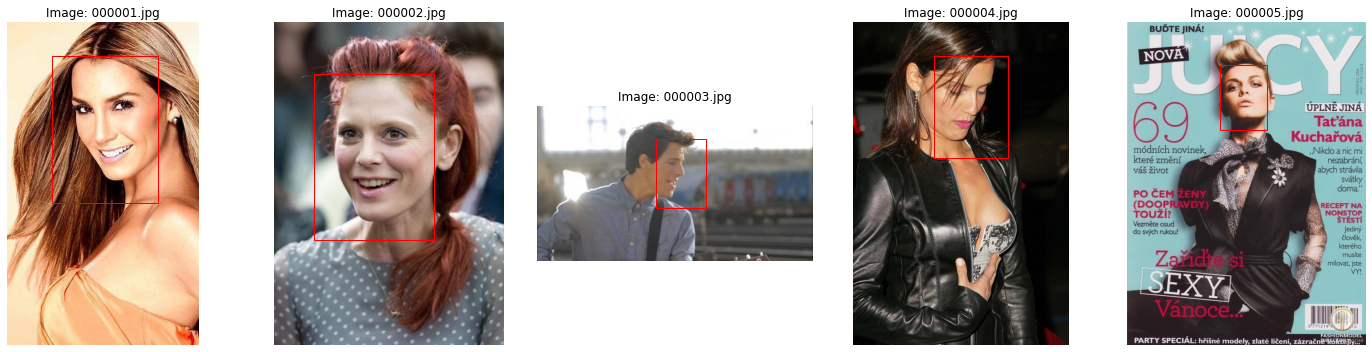

In [4]:
# Display first 5 images with bounding boxes and identity
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, row in merged_df.iterrows():
    if i >= 5:  # Only process the first 5 entries
        break
    img_path = os.path.join(images_dir, row['image_id'])
    img = Image.open(img_path)

    x = row['x_1']
    y = row['y_1']

    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), row['width'], row['height'], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    axs[i].imshow(img)
    axs[i].add_patch(rect)
    axs[i].set_title(f"Image: {row['image_id']}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# Create Data Set

In [5]:
class CelebADataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        original_width, original_height = image.size

        bbox = self.dataframe.iloc[idx, 1:5].values.astype('float')
        identity = self.dataframe.iloc[idx, 5]

        if self.transform:
            image = self.transform(image)
            new_width, new_height = 224, 224
            # Calculate scale factors
            scale_width = new_width / original_width
            scale_height = new_height / original_height
            # Adjust bounding box. Format assumed to be [x, y, width, height]
            bbox[0] = bbox[0] * scale_width  # x
            bbox[1] = bbox[1] * scale_height  # y
            bbox[2] = bbox[2] * scale_width  # width
            bbox[3] = bbox[3] * scale_height  # height

        sample = {'image': image, 'bbox': bbox, 'identity': identity}

        return sample

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
# Create instances of the dataset
train_dataset = CelebADataset(dataframe=train_df, images_dir=images_dir, transform=transform)
val_dataset = CelebADataset(dataframe=val_df, images_dir=images_dir, transform=transform)
test_dataset = CelebADataset(dataframe=test_df, images_dir=images_dir, transform=transform)


In [8]:
# Create data loaders
batch_size = 32  # You can adjust this size as per your computational resources

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print("Finished Validation Loading")

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print("Finished Test Loading")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Finished Train Loading")

Finished Validation Loading
Finished Test Loading
Finished Train Loading


In [9]:
counter = 0
for batch in train_loader:  # Corrected to use data_loader parameter
    images, bboxes, labels = batch['image'], batch['bbox'], batch['identity']
    print(counter + 1)
    counter += 1
    print(images.shape)
    print(bboxes.shape)
    print(labels.shape)
    break

1
torch.Size([32, 3, 224, 224])
torch.Size([32, 4])
torch.Size([32])


# Model

In [10]:
class YOLOModel(nn.Module):
    def __init__(self, n_classes):
        super(YOLOModel, self).__init__()
        # Load a pre-trained ResNet and remove its classifier
        backbone = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-2])

        # Adaptive pooling to handle varying sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        # The bounding box head: predicts [x_center, y_center, width, height]
        self.bbox_head = nn.Linear(512 * 7 * 7, 4)  # Adjust the size accordingly

        # The class prediction head
        self.class_head = nn.Linear(512 * 7 * 7, n_classes)  # n_classes is the number of unique identities

    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x)
        features = self.adaptive_pool(features)
        features = torch.flatten(features, 1)

        # Predict bounding boxes
        bboxes = self.bbox_head(features)

        # Predict classes
        classes = self.class_head(features)

        return bboxes, classes


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [12]:
def yolo_loss(predicted_bboxes, true_bboxes, predicted_classes, true_classes):
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()
    bbox_loss = mse_loss(predicted_bboxes, true_bboxes)
    class_loss = ce_loss(predicted_classes, true_classes)

    # Combine losses. You can also add weights.
    total_loss = bbox_loss + class_loss

    return total_loss

In [13]:
def save_model(model, file_name, directory='PyTorchModel'):
    # Check if the directory exists, if not, create it
    if not os.path.exists(directory):
        os.makedirs(directory)
    path = os.path.join(directory, file_name)
    torch.save(model.state_dict(), path)
    print(f'Model saved to {path}')


def load_model(file_name, num_classes, directory='PyTorchModel'):
    path = os.path.join(directory, file_name)
    # Initialize the model
    model = YOLOModel(n_classes=num_classes)
    # Load the model state dictionary
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    return model

In [14]:
file_name = 'yolo_model_regularized.pth'
# When you need to load the model
# Concatenate the dataframes
all_df = pd.concat([train_df, val_df, test_df])
num_classes = all_df['identity'].nunique()
try:
    model = load_model(file_name, num_classes)
    model = model.to(device)
    print("Model found\n Using trained model")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

except:
    print("No Model found\n Using Untrained model")
    model = YOLOModel(n_classes=num_classes)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


No Model found
 Using Untrained model


In [15]:
len(train_loader)


5087

# Training  

In [17]:
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        images, true_bboxes, true_labels = batch['image'].to(device), batch['bbox'].to(device), batch['identity'].to(
            device)
        true_labels -= 1
        max_label = max(true_labels).item()
        min_label = min(true_labels).item()
        assert min_label >= 0 and max_label < num_classes, f"Label out of range {max_label}, {min_label}, [0..{num_classes}]"
        images = images.float()
        true_bboxes = true_bboxes.float()

        # Forward pass
        pred_bboxes, pred_labels = model(images)

        # Compute loss
        loss = yolo_loss(pred_bboxes, true_bboxes, pred_labels, true_labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            images, true_bboxes, true_labels = batch['image'].to(device), batch['bbox'].to(device), batch[
                'identity'].to(device)
            true_labels -= 1
            max_label = max(true_labels).item()
            min_label = min(true_labels).item()
            assert min_label >= 0 and max_label < num_classes, f"Label out of range {max_label}, {min_label}, [0..{num_classes}]"

            images = images.float()
            true_bboxes = true_bboxes.float()

            # Forward pass
            pred_bboxes, pred_labels = model(images)

            # Compute loss
            loss = yolo_loss(pred_bboxes, true_bboxes, pred_labels, true_labels)

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")
    scheduler.step()
print("Done")

Epoch [1/10], Train Loss: 63.040663350793125, Val Loss: 49.034301696384205
Epoch [2/10], Train Loss: 31.027943548716564, Val Loss: 42.74975169453644
Epoch [3/10], Train Loss: 23.88242890508137, Val Loss: 40.05006247749267
Epoch [4/10], Train Loss: 18.52288553085312, Val Loss: 36.41610598909682
Epoch [5/10], Train Loss: 14.263091327400275, Val Loss: 40.22814197509569
Epoch [6/10], Train Loss: 6.958093927491032, Val Loss: 31.38434635537066
Epoch [7/10], Train Loss: 5.1430798285551615, Val Loss: 30.843258724120503
Epoch [8/10], Train Loss: 4.179179232880248, Val Loss: 31.06700402719003
Epoch [9/10], Train Loss: 3.5494899906530017, Val Loss: 30.473319411469735
Epoch [10/10], Train Loss: 3.1345251290578378, Val Loss: 29.9894180389994
Done


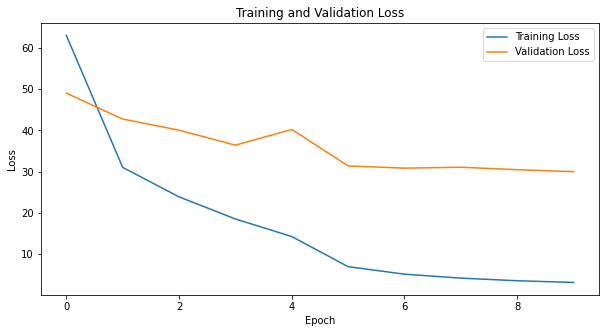

In [18]:

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [19]:
# After training, save the model
save_model(model, file_name)

Model saved to PyTorchModel/yolo_model_regularized.pth


In [20]:
def get_detections(bboxes, class_scores, threshold=0.5):
    """
    Process model outputs to get detections above a confidence threshold.
    Adjusted for single detection scenario with multiple class scores.
    """
    detections = []

    # Assuming class_scores is [1, num_classes]
    class_scores = class_scores.unsqueeze(0)  # This adds a batch dimension, making it [1, num_classes]

    class_probs = F.softmax(class_scores, dim=1)
    score_max, class_id = torch.max(class_probs, dim=1)

    if score_max > threshold:
        detections.append((bboxes.cpu().detach().numpy(), class_id.item(), score_max.item()))

    return detections


# Function to convert [x, y, width, height] to [x_min, y_min, x_max, y_max]
def convert_bbox_format(bbox):
    x_min, y_min = bbox[0], bbox[1]
    x_max, y_max = bbox[0] + bbox[2], bbox[1] + bbox[3]
    return [x_min, y_min, x_max, y_max]



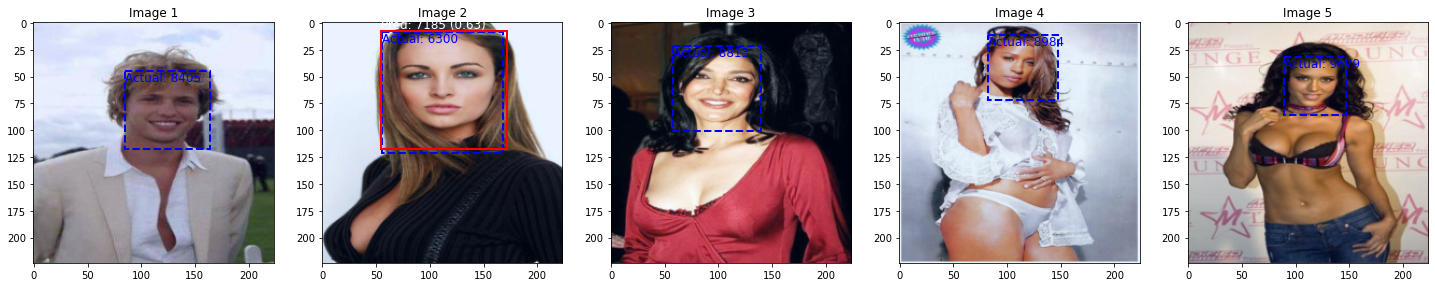

In [27]:

# Selecting 5 random images and their labels from the test dataset
indices = random.sample(range(len(test_dataset)), 5)
# Visualization loop
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i, idx in enumerate(indices):
    sample = test_dataset[idx]
    image_tensor, true_bbox, label = sample['image'], sample['bbox'], sample['identity']

    image_tensor_4d = image_tensor.unsqueeze(0).to(device)
    pred_bboxes, pred_scores = model(image_tensor_4d)
    pred_bboxes, pred_scores = pred_bboxes[0], pred_scores[0]  # Assuming first dimension is batch size
    # Get detections
    detections = get_detections(pred_bboxes, pred_scores, threshold=0.5)

    image_to_plot = image_tensor.permute(1, 2, 0).numpy()
    axs[i].imshow((image_to_plot - image_to_plot.min()) / (image_to_plot.max() - image_to_plot.min()))

    # Plot actual bbox and label
    actual_bbox = convert_bbox_format(true_bbox)
    rect = patches.Rectangle((actual_bbox[0], actual_bbox[1]), actual_bbox[2] - actual_bbox[0],
                             actual_bbox[3] - actual_bbox[1], linewidth=2, edgecolor='blue', facecolor='none',
                             linestyle='dashed')
    axs[i].add_patch(rect)
    axs[i].text(actual_bbox[0], actual_bbox[1], f'Actual: {label - 1}', color='blue', fontsize=12,
                verticalalignment='top')

    # Plot predicted bbox and label
    for bbox, class_id, score in detections:
        pred_bbox = convert_bbox_format(bbox)
        rect = patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1],
                                 linewidth=2, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)
        axs[i].text(pred_bbox[0], pred_bbox[1], f'Pred: {class_id} ({score:.2f})', color='white', fontsize=12,
                    verticalalignment='bottom')

    axs[i].set_title(f"Image {i + 1}")

plt.show()
